

<div style="font-style: bold; text-align: center;" markdown="1">

# Dogecoin price prediction with Gaussian Process

</div>

Predicting dogecoin price based on the past 6 months data using non-parametric gaussian process (GP). GPy library is used for the implementation. A custom kernel is explored. The model is optimized. 

* Dogecoin price data is extracted using `CoinGeckoAPI`

> Here I use Gaussian process to predic the stock price of Dogecoin. 

In [ ]:
#install few packages
#!pip install pycoingecko
#!pip install plotly
#!pip install mplfinance
#!pip install GPy

Import necessary libraries

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import plot
import datetime
from pycoingecko import CoinGeckoAPI
from mplfinance.original_flavor import candlestick2_ohlc

### Rest APIs function --> sending request via HTTP message.

Lets use CoinGeckoAPI to get dogecoin data

Lets start off by getting the data we need. Using the `get_coin_market_chart_by_id(id, vs_currency, days)`. id is the name of the coin we want, vs_currency is the currency you want the price in, and days is how many days back from today you want.



In [179]:
cg = CoinGeckoAPI()
#cg.get_coins_list()

dogecoin_data = cg.get_coin_market_chart_by_id(id='dogecoin', vs_currency = 'usd', days=360)
#dogecoin_data = cg.get_coin_history_by_id(id='dogecoin', vs_currency = 'usd', date = '21-09-2021')

In [180]:
dogecoin_data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [181]:
dogecoin_data

{'prices': [[1616716800000, 0.051008121907801525],
  [1616803200000, 0.05383361221420606],
  [1616889600000, 0.05478730183777124],
  [1616976000000, 0.05440374211637906],
  [1617062400000, 0.05489761687002298],
  [1617148800000, 0.054648888880952526],
  [1617235200000, 0.05438168841092798],
  [1617321600000, 0.06159286209766597],
  [1617408000000, 0.05786700851554392],
  [1617494400000, 0.056190733054659645],
  [1617580800000, 0.05789756018165116],
  [1617667200000, 0.05981544389374014],
  [1617753600000, 0.06463255671171673],
  [1617840000000, 0.058961028299255425],
  [1617926400000, 0.06167975458140067],
  [1618012800000, 0.061538922422549734],
  [1618099200000, 0.06388288909608833],
  [1618185600000, 0.07464630224891416],
  [1618272000000, 0.07102437005748706],
  [1618358400000, 0.09377852573438977],
  [1618444800000, 0.12017223326194178],
  [1618531200000, 0.17986179256214438],
  [1618617600000, 0.3741602130190218],
  [1618704000000, 0.28510938733297203],
  [1618790400000, 0.320030

### Convert the dic to panda dataframe

In [182]:
#convert into panda dataframe
dogecoin_price_data = dogecoin_data['prices']
doge_data = pd.DataFrame(dogecoin_price_data, columns=['TimeStamp', 'Price'])

In [183]:
doge_data.head()

,TimeStamp,Price
0,1616716800000,0.051008
1,1616803200000,0.053834
2,1616889600000,0.054787
3,1616976000000,0.054404
4,1617062400000,0.054898


Convert the timestamp and save it to a new column as `Date`. We will map `unix_to_datetime` to each timestamp and convet it to a readable date time

In [184]:
doge_data['date'] = doge_data['TimeStamp'].apply(lambda d: datetime.date.fromtimestamp(d/1000.0))

In [185]:
doge_data.head()

,TimeStamp,Price,date
0,1616716800000,0.051008,2021-03-26
1,1616803200000,0.053834,2021-03-27
2,1616889600000,0.054787,2021-03-28
3,1616976000000,0.054404,2021-03-29
4,1617062400000,0.054898,2021-03-30


Using this modified dataset we can now group by the `Date` and find the min, max, open and close for the candlesticks.

In [186]:
candlestick_data = doge_data.groupby(doge_data.date, as_index=False).agg({"Price":['min','max','first','last']}) #aggregate function
candlestick_data.head()

date     Price                              
                    min       max     first      last
0  2021-03-26  0.051008  0.051008  0.051008  0.051008
1  2021-03-27  0.053834  0.053834  0.053834  0.053834
2  2021-03-28  0.054787  0.054787  0.054787  0.054787
3  2021-03-29  0.054404  0.054404  0.054404  0.054404
4  2021-03-30  0.054898  0.054898  0.054898  0.054898

In [187]:
fig = go.Figure (data=[go.Candlestick(x=candlestick_data['date'],
                open=candlestick_data['Price']['first'], 
                high=candlestick_data['Price']['max'],
                low=candlestick_data['Price']['min'], 
                close=candlestick_data['Price']['last'])
                ])

fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

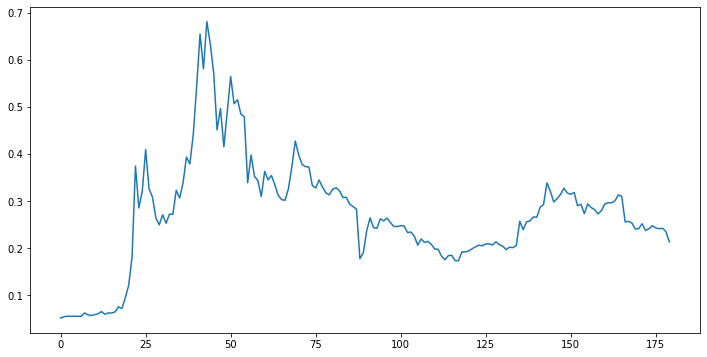

In [248]:
ax = plt.figure(figsize = (12,6))
plt.plot( candlestick_data['Price']['last'], '-')

In [189]:
#extract data index 
data_index =  candlestick_data.index + 1
closing_price = candlestick_data['Price']['last']


Lets create a new data frame with only data index in days and the closing price for each day

In [190]:
doge_dict = {'dataindex': data_index, 'closing price': closing_price}
doge_df = pd.DataFrame(data = doge_dict)
doge_df.head()

,dataindex,closing price
0,1,0.051008
1,2,0.053834
2,3,0.054787
3,4,0.054404
4,5,0.054898


Now we have a time series data of dogecoin with closing price from the last 1 year. We will use this dataframe as our data to make inference with the GPs. For that, we take this data and split it into training and testing points. 

In [191]:
doge_df.describe()

,dataindex,closing price
count,180.000000,180.000000
mean,90.500000,0.272051
std,52.105662,0.120027
min,1.000000,0.051008
25%,45.750000,0.206193
50%,90.500000,0.264632
75%,135.250000,0.323252
max,180.000000,0.681842


As we can see the mean of the price is not zero. To simplify, we normalize the data to have mean zero. This can be done by subtracting the mean from each data point. 

In [192]:
price_mean = np.mean(doge_df['closing price'])
doge_df['closing price'] = doge_df['closing price'] - price_mean
doge_df.describe()

,dataindex,closing price
count,180.000000,1.800000e+02
mean,90.500000,1.480297e-17
std,52.105662,1.200274e-01
min,1.000000,-2.210434e-01
25%,45.750000,-6.585807e-02
50%,90.500000,-7.419270e-03
75%,135.250000,5.120094e-02
max,180.000000,4.097901e-01


In [193]:
new_mean = doge_df.describe()['closing price']['mean']

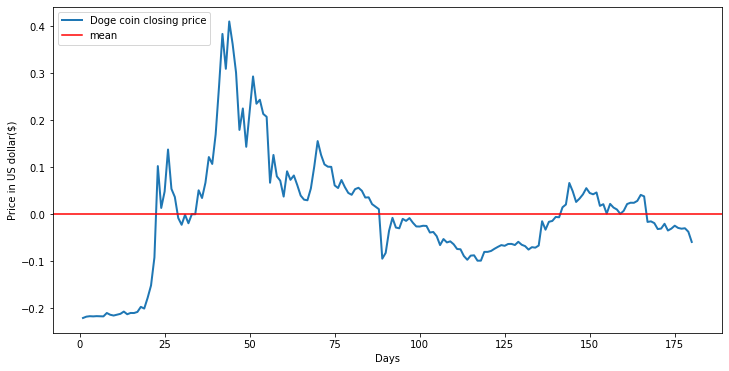

In [249]:
ax = plt.figure(figsize = (12,6))
plt.plot( doge_df['dataindex'], doge_df['closing price'], linewidth = 2.0, label = 'Doge coin closing price')
plt.axhline(y=new_mean, color='r', linestyle='-', label = "mean")
plt.legend(loc = "upper left")
plt.xlabel('Days')
plt.ylabel('Price in US dollar($)')
plt.show()

Use scikitlearn library to split the data into train and test set

In [195]:
from sklearn.model_selection import train_test_split

In [196]:
#Convert to numpy array and change to a column vector with reshape
X = np.array(doge_df['dataindex']).reshape(-1,1)
y = np.array(doge_df['closing price']).reshape(-1,1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size = 0.4, random_state=42)

In addition to the randomized train and test data, we also want to divide the dataset in a chronological order, to evaluate how well GPs can predict price prediction.

In [234]:
split_ratio=0.8
split_indx=int(len(X)*split_ratio)
X_train2 = X[:split_indx]
X_test2 = X[split_indx:]
y_train2 = y[:split_indx]
y_test2 = y[split_indx:]


### Setting up parameters and kernels for gaussian process

In [198]:
import GPy

In [264]:
#RBF = GPy.kern.RBF(input_dim=1)
#RBF2 = GPy.kern.RBF(input_dim=1)
#kern = RBF  + RBF2i
RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=5)
LIN = GPy.kern.Linear(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(input_dim=1, variance=3)
kern= RBF+LIN+PERIODIC*RBF2



In [265]:
np.size(X)

180

Text(0.5, 1.0, 'Sample 10 functions(prior) from a GP')

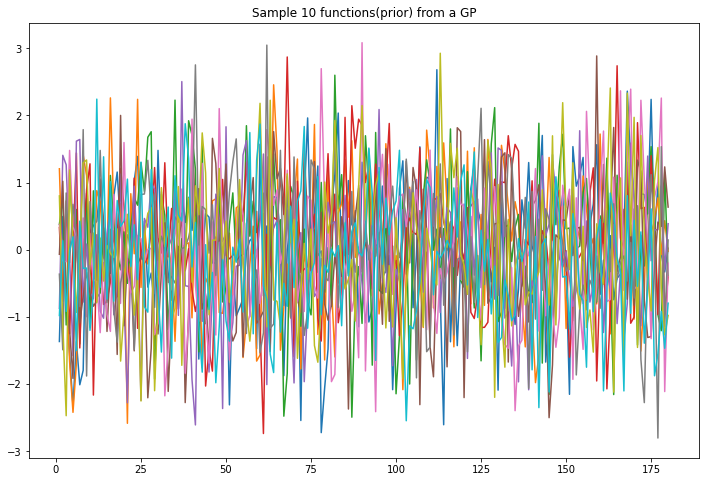

In [281]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.2)
size = np.size(X)
mu = np.zeros((size))
C = k.K(X,X)
# 500 points evenly spaced over [0,1]
# reshape X to make it n*D
# vector of the means
# covariance matrix
# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)
plt.figure(figsize = (12,8)) # open new plotting window 
for i in range(10):
    plt.plot(X[:],Z[i,:])
plt.title('Sample 10 functions(prior) from a GP')


In [ ]:
m = GPy.models.GPRegression(X_train1,y_train1,kern)
m.optimize()
display(m)

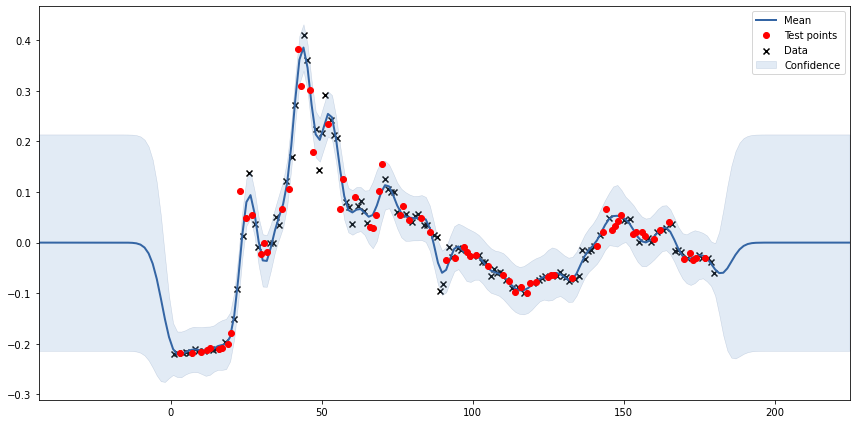

In [247]:
ax = m.plot(figsize = (12,6))
plt.plot(X_test1, y_test1, "ro", mew=1, label='Test points')
plt.legend(loc = 'upper right')

After optimisation, it seems that the test points are right along where the predictive function mean is. Given lots of missing data, GP can be useful to predict the missing data. However, as we can see that after the last data point, the mean predictive function returns back to initial stage. Now, let's see how GPs would learn the mean function for a chronological data.   

{'covariance': [[<matplotlib.lines.Line2D at 0x155445430>]]}

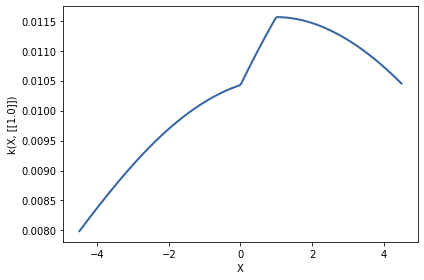

In [250]:
kern.plot()

In [202]:
def visualize_covariance(K):
    """Helper function for visualizing a covariance matrix on the training data."""
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(K, interpolation='None')
    plt.colorbar(im)


In [203]:
#periodic = GPy.kern.Exponential(input_dim=1)
#visualize_covariance(kern.K(X_train1))

In [240]:
RBF = GPy.kern.RBF(input_dim=1)
BRN = GPy.kern.Brownian(input_dim=1)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=4)
LIN = GPy.kern.Linear(1)
#RQ=GPy.kern.RatQuad(1)
#RQ2=GPy.kern.RatQuad(input_dim=1, variance=3)
kern= RBF + BRN + PERIODIC



In [241]:
m1 = GPy.models.GPRegression(X_train2,y_train2,kern)
m1.optimize()
display(m1)

GP_regression.,value,constraints,priors
sum.rbf.variance,0.01052245649703662,+ve,
sum.rbf.lengthscale,7.412412469792606,+ve,
sum.Brownian.variance,0.0010363732149517785,+ve,
sum.periodic_Matern52.variance,0.07634669241066906,+ve,
sum.periodic_Matern52.lengthscale,7.919824239432984,+ve,
sum.periodic_Matern52.period,3.412202124269067,+ve,
Gaussian_noise.variance,0.000233714658812758,+ve,


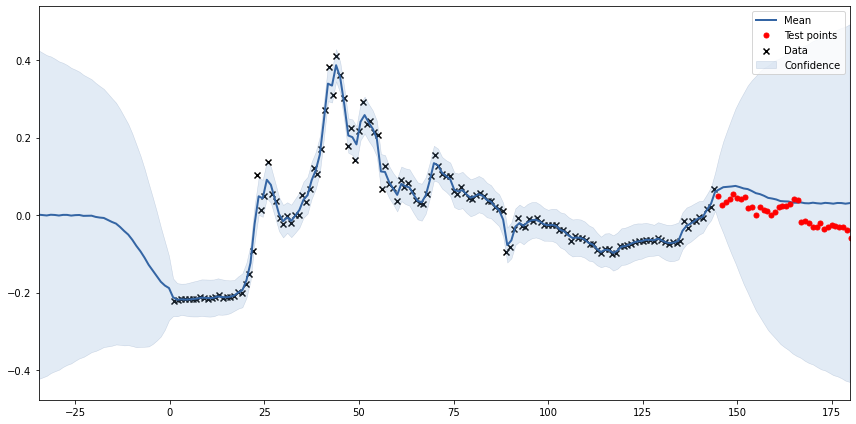

In [283]:

m1.plot(figsize = (12,6))
plt.plot(X_test2, y_test2, "ro", markersize=5, label='Test points')
plt.legend(loc = 'upper right')


Text(0.5, 1.0, 'Covariane matrix - kernel')

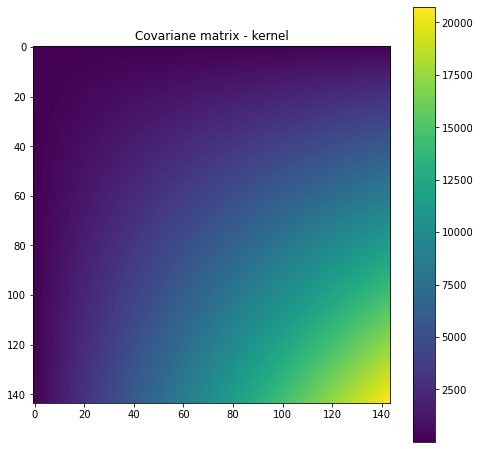

In [285]:
visualize_covariance(kern.K(X_train2))
plt.title('Covariane matrix - kernel')